In [1]:
import pandas as pd
import numpy as np
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

In [2]:
df = pd.read_csv('../database/preprocessed_content_analysis.csv', index_col=0)
df

,first_name,middle_name,last_name,email,institution,award_year,award_amount,paper_title,journal,publication_year,...,citation_2019,citation_2020,citation_2021,citation_2022,citation_2023,citation_2024,tokenized_title,normalized_title,tokenized_abstract,normalized_abstract
0,Talal,NaN,Asad,talalasad@earthlink.net,cuny graduate school university center,2011,19901,Effect of oxidation and geometrical dimensions...,Desalination,2011,...,13,5,10,5,7,1,"['Effect', 'of', 'oxidation', 'and', 'geometri...","['effect', 'oxidation', 'geometrical', 'dimens...","['This', 'study', 'reports', 'for', 'the', 'fi...","['study', 'report', 'time', 'use', 'oxidize', ..."
1,Talal,NaN,Asad,talalasad@earthlink.net,cuny graduate school university center,2011,19901,Synthesis and biological evaluation of new pyr...,Molecules,2014,...,13,5,10,5,7,1,"['Synthesis', 'and', 'biological', 'evaluation...","['synthesis', 'biological', 'evaluation', 'new...","['A', 'selected', 'set', 'of', 'substituted', ...","['select', 'set', 'substituted', 'pyridone', '..."
2,Talal,NaN,Asad,talalasad@earthlink.net,cuny graduate school university center,2011,19901,"Synthesis of 6-Ethyl-1, 2, 9-trioxopyrrolo [3,...",Zeitschrift für Naturforschung B,2013,...,13,5,10,5,7,1,"['Synthesis', 'of', '6', 'Ethyl-1', '2', '9', ...","['synthesis', 'ethyl-1', 'trioxopyrrolo', 'f',...","['Interaction', 'of', '6', 'amino-1', 'ethyl-4...","['interaction', 'amino-1', 'ethyl-4', 'oxoquin..."
3,Talal,NaN,Asad,talalasad@earthlink.net,cuny graduate school university center,2011,19901,"Randa M. Al-As’ ada, Mustafa M. El-abadelaha, ...",Z. Naturforsch,2013,...,13,5,10,5,7,1,"['Randa', 'M.', 'Al', 'As', 'ada', 'Mustafa', ...","['randa', 'm.', 'al', 'ada', 'mustafa', 'm.', ...","['Interaction', 'of', '6', 'amino-1', 'ethyl-4...","['interaction', 'amino-1', 'ethyl-4', 'oxoquin..."
4,Leaf,NaN,Van Boven,vanboven@colorado.edu,university of colorado at boulder,2011,250000,Identifiable but not identical: Combining soci...,Journal of Consumer research,2012,...,868,1234,1132,1198,1222,179,"['Identifiable', 'but', 'not', 'identical', 'C...","['identifiable', 'identical', 'combine', 'soci...","['How', 'do', 'consumers', 'reconcile', 'confl...","['consumer', 'reconcile', 'conflicting', 'moti..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115403,Francis,J,Magilligan,francis.j.magilligan@dartmouth.edu,dartmouth college,2020,427479,Assessing the Impacts of Extreme Precipitation...,AGU Fall Meeting Abstracts,2020,...,453,500,457,549,582,101,"['Assessing', 'the', 'Impacts', 'of', 'Extreme...","['assess', 'impact', 'extreme', 'precipitation...","['Floods', 'have', 'a', 'devastating', 'impact...","['flood', 'devastating', 'impact', 'infrastruc..."
115404,Francis,J,Magilligan,francis.j.magilligan@dartmouth.edu,dartmouth college,2020,427479,What is Fluvial Geomorphic Equilibrium?: Evalu...,AGU Fall Meeting Abstracts,2019,...,453,500,457,549,582,101,"['What', 'is', 'Fluvial', 'Geomorphic', 'Equil...","['fluvial', 'geomorphic', 'equilibrium', 'eval...","['Various', 'definitions', 'of', 'equilibrium'...","['definition', 'equilibrium', 'alluvial', 'cha..."
115405,Francis,J,Magilligan,francis.j.magilligan@dartmouth.edu,dartmouth college,2020,427479,Bankfull Channel Adjustments to Episodic and L...,AGU Fall Meeting Abstracts,2019,...,453,500,457,549,582,101,"['Bankfull', 'Channel', 'Adjustments', 'to', '...","['bankfull', 'channel', 'adjustment', 'episodi...","['The', 'bankfull', 'Shields', 'value', 'is', ...","['bankfull', 'shield', 'value', 'increasingly'..."
115406,Francis,J,Magilligan,francis.j.magilligan@dartmouth.edu,dartmouth college,2020,427479,Elevated post-event sediment yield extends the...,AGU Fall Meeting Abstracts,2018,...,453,500,457,549,582,101,"['Elevated', 'post', 'event', 'sediment', 'yie...","['elevate', 'post', 'event', 'sediment', 'yiel...","['The', 'long', 'term', 'effects', 'of', 'cata...","['long', 'term', 'effect', 'catastrophic', 'fl..."


In [3]:
# prepare data for cluatering
df['normalized_abstract'] = df['normalized_abstract'].apply(ast.literal_eval)
df['normalized_abstract'] = df['normalized_abstract'].apply(lambda x: ' '.join(x))

In [4]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# generate TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(df['normalized_abstract'])

In [5]:
# fit SVD
n_components = min(tfidf_matrix.shape) - 1
svd = TruncatedSVD(n_components=n_components)
svd.fit(tfidf_matrix)

# calculate the cumulative explained variance ratio
cumulative_explained_variance = np.cumsum(svd.explained_variance_ratio_)

# calculate the number of SVD components capturing 95% variance 
num_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
num_components

871

In [6]:
# fit and transform TF-IDF matrix
svd = TruncatedSVD(n_components=871)
tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)

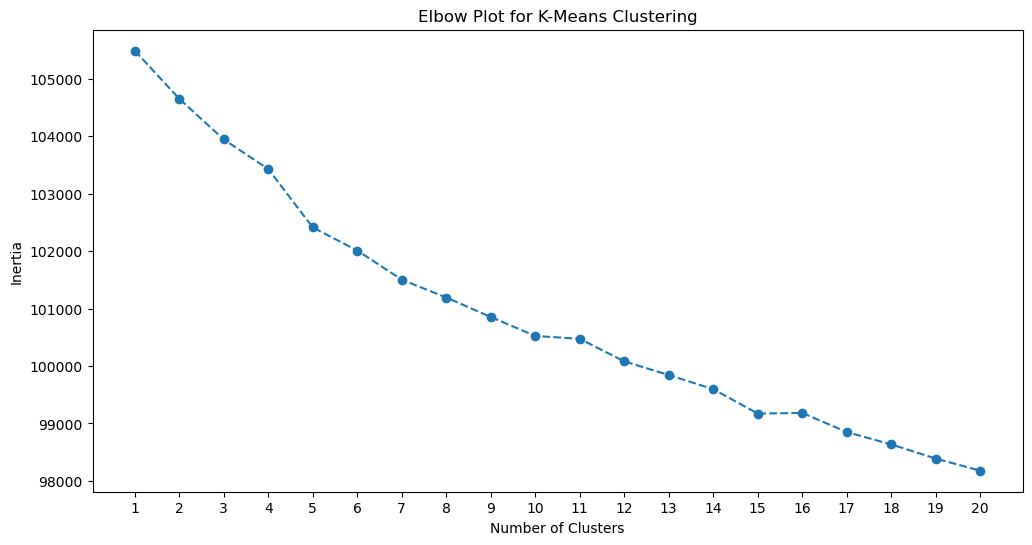

In [7]:
num_clusters = range(1, 21)

# calculate the inertia for each number of clusters
inertias = []
for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix_reduced)
    inertias.append(kmeans.inertia_)

# Plot the elbow plot
plt.figure(figsize=(12, 6))
plt.plot(num_clusters, inertias, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Plot for K-Means Clustering')
plt.xticks(num_clusters)
plt.show()

In [19]:
# perform K-means clustering on TF-IDF matrix
kmeans_tfidf = KMeans(n_clusters=5, random_state=42)
kmeans_tfidf.fit(tfidf_matrix_reduced)

# add cluster labels to the dataframe
df['tfidf_cluster'] = kmeans_tfidf.labels_

In [9]:
# Word2Vec Vectorization
word2vec_model = Word2Vec(sentences=df['normalized_abstract'].sum(), vector_size=300, window=5, min_count=10, sg=1)

def vectorize(abstract, model):
    vector = np.mean([model.wv[word] for word in abstract if word in model.wv] or [np.zeros(model.vector_size)], axis=0)
    return vector

# generate Word2Vec vectors
w2v_vectors = np.vstack(df['normalized_abstract'].apply(lambda x: vectorize(x, word2vec_model)))

In [10]:
# fit PCA
pca = PCA().fit(w2v_vectors)

# calculate the cumulative explained variance ratio
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# calculate the number of PCA components capturing 95% variance 
num_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
num_components

21

In [11]:
# fit and transform Word2Vec vectors
pca = PCA(n_components=21)
w2v_vectors_reduced = pca.fit_transform(w2v_vectors)

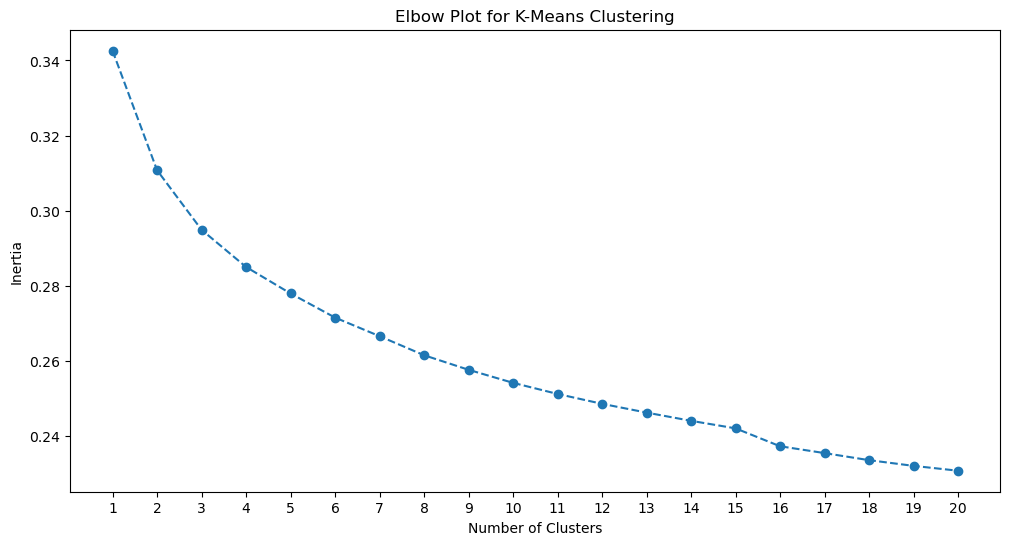

In [12]:
num_clusters = range(1, 21)

# calculate the inertia for each number of clusters
inertias = []
for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(w2v_vectors_reduced)
    inertias.append(kmeans.inertia_)

# Plot the elbow plot
plt.figure(figsize=(12, 6))
plt.plot(num_clusters, inertias, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Plot for K-Means Clustering')
plt.xticks(num_clusters)
plt.show()

In [22]:
# perform K-means clustering on Word2Vec vectors
kmeans_w2v = KMeans(n_clusters=5, random_state=42)
kmeans_w2v.fit(w2v_vectors_reduced)

# add cluster labels to the dataframe
df['w2v_cluster'] = kmeans_w2v.labels_

In [14]:
# function to find the most distinctive words in each cluster
def find_distinctive_words_by_cluster(clusters):
    aggregate_tfidf_vectors_by_cluster = {}
    
    for i, cluster in enumerate(clusters):
        if cluster not in aggregate_tfidf_vectors_by_cluster:
            aggregate_tfidf_vectors_by_cluster[cluster] = tfidf_matrix[i]
        else:
            aggregate_tfidf_vectors_by_cluster[cluster] += tfidf_matrix[i]

    distinctive_words_by_cluster = {}
    feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
    
    for cluster, agg_tfidf in aggregate_tfidf_vectors_by_cluster.items():
        sorted_indices = np.argsort(agg_tfidf.toarray()).flatten()[::-1]
        distinctive_words_by_cluster[cluster] = feature_names[sorted_indices][:20]

    for cluster, words in distinctive_words_by_cluster.items():
        print(f"Cluster {cluster}: {words}")

In [20]:
# find the most distinctive words in each TF-IDF cluster
find_distinctive_words_by_cluster(df['tfidf_cluster'])

Cluster 1: ['social' 'study' 'human' 'research' 'datum' 'group' 'health' 'individual'
 'population' 'analysis' 'model' 'child' 'high' 'people' 'new' 'behavior'
 'examine' 'include' 'system' 'development']
Cluster 4: ['task' 'memory' 'visual' 'object' 'model' 'word' 'brain' 'experiment'
 'study' 'information' 'participant' 'speech' 'neural' 'stimulus' 'learn'
 'effect' 'child' 'processing' 'control' 'response']
Cluster 0: ['language' 'linguistic' 'english' 'speaker' 'word' 'bilingual' 'sign'
 'l2' 'speech' 'child' 'spanish' 'study' 'speak' 'native' 'learner'
 'acquisition' 'use' 'research' 'processing' 'learn']
Cluster 3: ['site' 'climate' 'change' 'date' 'region' 'water' 'archaeological'
 'record' 'datum' 'early' 'period' 'land' 'forest' 'year' 'area' 'human'
 'late' 'analysis' 'large' 'sediment']
Cluster 2: ['de' 'la' 'en' 'que' 'el' 'los' 'las' 'se' 'del' 'et' 'al' 'social'
 'maya' 'site' 'question' 'regional' 'base' 'cultural' 'article' 'central']


In [21]:
# create a new mapping dictionary for each TF-IDF cluster
tfidf_cluster_mapping = {
    0: 'Linguistics',
    1: 'Psychology',
    2: 'Spanish Studies',
    3: 'Environmental Studies',
    4: 'Cognitive Science'
}

# apply the new mapping to the TF-IDF cluster labels
df['tfidf_cluster'] = df['tfidf_cluster'].map(tfidf_cluster_mapping)

In [23]:
# find the most distinctive words in each Word2Vec cluster
find_distinctive_words_by_cluster(df['w2v_cluster'])

Cluster 2: ['study' 'language' 'human' 'social' 'individual' 'information' 'change'
 'model' 'brain' 'result' 'network' 'population' 'datum' 'analysis' 'task'
 'attention' 'high' 'effect' 'examine' 'region']
Cluster 0: ['social' 'study' 'human' 'model' 'research' 'datum' 'group' 'provide'
 'change' 'process' 'population' 'food' 'analysis' 'child' 'work' 'high'
 'new' 'approach' 'include' 'system']
Cluster 4: ['language' 'study' 'child' 'model' 'research' 'effect' 'change'
 'experience' 'human' 'speech' 'experiment' 'word' 'use' 'result' 'time'
 'present' 'people' 'evidence' 'system' 'level']
Cluster 3: ['study' 'datum' 'research' 'result' 'model' 'system' 'time' 'base' 'task'
 'effect' 'present' 'participant' 'use' 'test' 'measure' 'response'
 'analysis' 'target' 'high' 'visual']
Cluster 1: ['language' 'de' 'human' 'datum' 'change' 'study' 'analysis' 'site' 'age'
 'year' 'early' 'model' 'large' 'child' 'area' 'la' 'high' 'new' 'use'
 'region']


In [24]:
# # create a new mapping dictionary for each Word2Vec cluster
w2v_cluster_mapping = {
    0: 'Social Psychology',
    1: 'Archaeology',
    2: 'Cognitive Science',
    3: 'Experimental Studies',
    4: 'Linguistics'
}

# apply the new mapping to the Word2Vec cluster labels
df['w2v_cluster'] = df['w2v_cluster'].map(w2v_cluster_mapping)

In [25]:
cluster_df = df[['email', 'tfidf_cluster', 'w2v_cluster']]
cluster_df

,email,tfidf_cluster,w2v_cluster
0,talalasad@earthlink.net,Psychology,Cognitive Science
1,talalasad@earthlink.net,Psychology,Social Psychology
2,talalasad@earthlink.net,Psychology,Social Psychology
3,talalasad@earthlink.net,Psychology,Social Psychology
4,vanboven@colorado.edu,Psychology,Cognitive Science
...,...,...,...
115403,francis.j.magilligan@dartmouth.edu,Environmental Studies,Experimental Studies
115404,francis.j.magilligan@dartmouth.edu,Psychology,Social Psychology
115405,francis.j.magilligan@dartmouth.edu,Environmental Studies,Archaeology
115406,francis.j.magilligan@dartmouth.edu,Environmental Studies,Social Psychology


In [26]:
cluster_df.to_csv('cluster_by_paper.csv')